In [4]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import cv2
import random

In [5]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [6]:
def colour_for_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

In [7]:
COCO_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [8]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [COCO_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

In [9]:
def instance_segmentation_api(img_path, threshold=0.5, rect_th=2, text_size=2, text_th=2):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = colour_for_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
        cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (255,0,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [10]:
colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
a,b,c=colours[0]

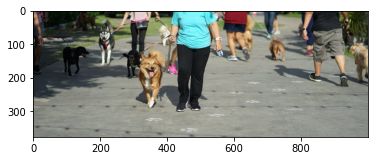

In [27]:
img = Image.open('Mdemo.jpg')
plt.imshow(img)
plt.show()

In [28]:
transform = T.Compose([T.ToTensor()])
img = transform(img)
pred = model([img])

In [29]:
masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
masks.shape

(46, 377, 1000)

In [30]:
pred[0]

{'boxes': tensor([[4.0042e+02, 1.3066e+00, 5.6843e+02, 3.1133e+02],
         [7.9754e+02, 2.5677e+00, 9.4772e+02, 2.2542e+02],
         [3.1034e+02, 1.2230e+02, 3.9377e+02, 2.9298e+02],
         [2.5680e+02, 3.7168e-01, 3.6099e+02, 1.2803e+02],
         [7.0313e+02, 8.5364e+01, 7.5452e+02, 1.5132e+02],
         [8.7465e+01, 1.0725e+02, 1.6428e+02, 1.9650e+02],
         [5.5751e+02, 5.4530e+00, 6.4775e+02, 1.5609e+02],
         [6.8826e+02, 1.6134e+00, 7.3665e+02, 8.4411e+01],
         [1.2755e+00, 1.3017e+00, 3.7273e+01, 1.8957e+02],
         [2.5991e+02, 1.1850e+02, 3.3104e+02, 2.0249e+02],
         [6.2764e+02, 1.4555e+01, 6.5996e+02, 1.2256e+02],
         [1.9453e+02, 4.3309e+01, 2.4644e+02, 1.6459e+02],
         [7.0940e+02, 4.0453e+00, 7.4451e+02, 7.6291e+01],
         [3.0323e+02, 9.3880e+00, 3.4421e+02, 6.2733e+01],
         [9.4228e+02, 9.9969e+01, 9.9991e+02, 2.1781e+02],
         [8.0247e+02, 3.0116e+00, 8.3842e+02, 1.3751e+02],
         [9.8178e+00, 1.0255e+00, 4.1647e+01, 8

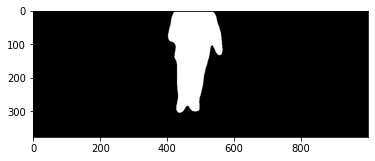

In [31]:
plt.imshow(masks[0], cmap='gray')
plt.show()

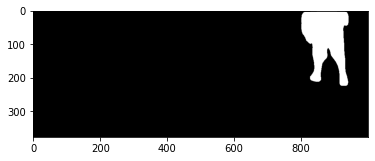

In [32]:
plt.imshow(masks[1], cmap='gray') 
plt.show()

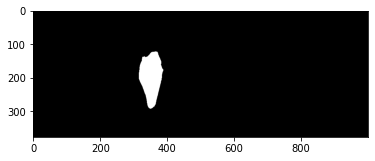

In [33]:
plt.imshow(masks[2], cmap='gray') 
plt.show()

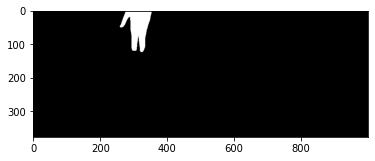

In [34]:
plt.imshow(masks[3], cmap='gray') 
plt.show()

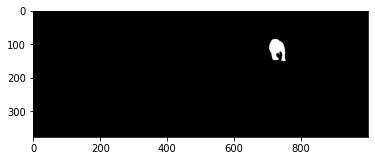

In [35]:
plt.imshow(masks[4], cmap='gray') 
plt.show()

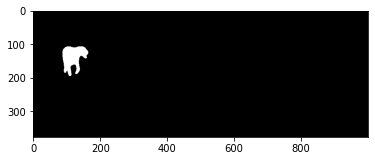

In [36]:
plt.imshow(masks[5], cmap='gray') 
plt.show()

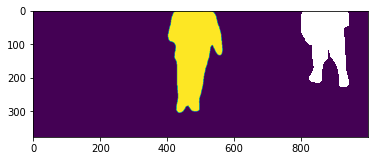

In [37]:
import numpy.ma as ma

combined_masks = ma.masked_array(masks[0] > 0, masks[1])
plt.imshow(combined_masks)
plt.show()

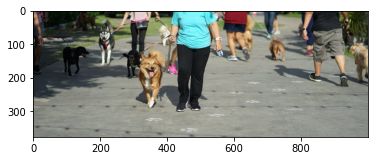

In [40]:
import matplotlib.image as mpimg
img=mpimg.imread('Mdemo.jpg')
plt.imshow(img)
plt.show()

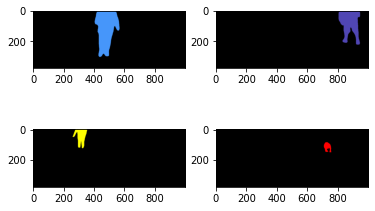

In [47]:
mask1 = colour_for_masks(masks[0])
mask2 = colour_for_masks(masks[1])
mask3 = colour_for_masks(masks[3])
mask4 = colour_for_masks(masks[4])
plt.subplot(2,2,1)
plt.imshow(mask1)
plt.subplot(2,2,2)
plt.imshow(mask2)
plt.subplot(2,2,3)
plt.imshow(mask3)
plt.subplot(2,2,4)
plt.imshow(mask4)
plt.show()

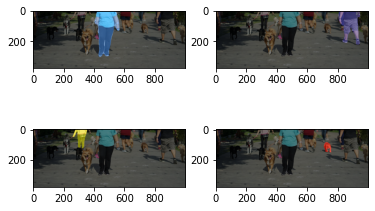

In [50]:
masked1 = cv2.addWeighted(img, 0.5, mask1, 0.5, 0)
masked2 = cv2.addWeighted(img, 0.5, mask2, 0.5, 0)
masked3= cv2.addWeighted(img, 0.5, mask3,0.5, 0)
masked4= cv2.addWeighted(img, 0.5, mask4,0.5, 0)

plt.subplot(2,2,1)
plt.imshow(masked1)
plt.subplot(2,2,2)
plt.imshow(masked2)
plt.subplot(2,2,3)
plt.imshow(masked3)
plt.subplot(2,2,4)
plt.imshow(masked4)
plt.show()